## Imports

Statistics and image processing

In [236]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import statistics
import mahotas
import bisect
import imutils

Video processing tools

In [237]:
from __future__ import unicode_literals
import youtube_dl
import os            # Folder paths
import sys           # Exit function
import glob          # Folder searching

from moviepy.editor import VideoFileClip  # Video processing - speeding up
import moviepy.video.fx.all as vfx

## Video/image processing functions

In [238]:
def displayImage(title, image):
    """

    Use opencv's functionality to display an image

    Args:
        title (str): A title for the pop-up window
        image      : Image to be displayed

    """
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    
    
def displayCentroid(key_list, img):
    """

    Use opencv's functionality to display detected keys on the keyboard

    Args:
        key_list (str, float) : Array of notes and their x-coordinate
        img (image)           : Image to be displayed

    """
    img_height = img.shape[0]
    display_heights = [img_height * 1 // 5, img_height * 2 // 5, img_height * 3 // 5, img_height * 4 // 5]
    counter = 0;
        
    # Loop through all keys
    for (note, centroid) in key_list: 
        font = cv2.FONT_HERSHEY_SIMPLEX
        line = cv2.line(img,(int(centroid),0),(int(centroid),img_height),(0,0,255),1)
        text_label = cv2.putText(img, note, (int(centroid), display_heights[counter % 4]), font, 0.5, (0,255,0), 1)
        
        counter += 1
        
        cv2.imshow("Key Label", img)
        cv2.waitKey(0)
        
    cv2.destroyAllWindows()

Detect keys, given a binarized image.

In [239]:
def getConnectedComponents(binarized_img, connectivity = 4):
    """

    Given a binarized (black and white) image, detect components with a given connectivity value

    Args:
        binarized_img (image): the 8-bit single-channel image to be labeled
        connectivity (int)   : 8 or 4 for 8-way or 4-way connectivity respectively

    Returns:
        num_labels (int)           : Number of detected components
        labels (int)               : 
        stats (array of floats)    : Array with the components x, y, width, height and area
        centroids (array of tuples): Array with the components' centroid (x,y coordinates)
    """
    connections = cv2.connectedComponentsWithStats(binarized_img, connectivity, cv2.CV_32S)
    
    num_labels = connections[0]
    labels = connections[1]
    stats = connections[2]
    centroids = connections[3]
    
    return num_labels, labels, stats, centroids

def getKeyStats(index, stats_array):
    """

    Given stats from cv2's connectedComponents' function

    Args:
        index (int)                   : Index of the array
        stats_array (array of floats) : Array with the components x, y, width, height and area

    Returns:
        x (float)    : Coordinates (from the top-left) of the component
        y (float)    : 
        w (float)    : Width (in pixels)
        h (float)    : Height (in pixels)
        area (float) : Area (in pixels)
    """
    x = stats_array[index, cv2.CC_STAT_LEFT]
    y = stats_array[index, cv2.CC_STAT_TOP]
    w = stats_array[index, cv2.CC_STAT_WIDTH]
    h = stats_array[index, cv2.CC_STAT_HEIGHT]
    area = stats_array[index, cv2.CC_STAT_AREA]
    
    return x, y, w, h, area
    
def displayDetectedKeys(image, labels, index, x, y, width, height, centroid_x, centroid_y):
    """

    Display the detected keys (and its associated centroid) on the original image

    """
    cv2.rectangle(image, (x,y), (x+width, y+height), (0,0,255),1)
    cv2.circle(image, (int(centroid_x), int(centroid_y)), 4, (255,255,0), -1)
    componentMask = (labels == index).astype("uint8") * 255
    cv2.imshow("Output", image)
    cv2.waitKey(0)

    
# function for doing connected components
def findKeys(binarized_img, original_img, display_result, min_key_area = 100):
    """

    Detect the keys in a given image

    Args:
        binarized_img (image) : Binarized image
        original_img (image)  : Original image (for displaying back onto)
        display_result (bool) : True if displaying results is desired
        min_key_area (int)    : Minimum area to be considered a key

    Returns:
        key_array (int, float)   : Index of the key and its' associated x-coordinate centroid
        key_median_width (float) : Median width of all detected keys
        
    """
    key_array = []
    
    num_labels, labels, stats, centroids = getConnectedComponents(binarized_img)
    key_median_width = statistics.median(stats[:, cv2.CC_STAT_WIDTH])
   
    # Loop through all the identified components
    for i in range(1, num_labels):
        # Get statistics for each detected component
        # key_x...h are the rectangular values associated (from the top-left)
        # cX, cY is the centroid of the detected component
        key_x, key_y, key_w, key_h, key_area = getKeyStats(i, stats)
        (cX, cY) = centroids[i]
        
        # If the area of a component is over a threshold, assume it is a key
        if (min_key_area < key_area < np.inf):
            key_array.append([i,cX])
            
            # If the user wants to use cv2 to display the detected keys on the image
            if (display_result):
                displayDetectedKeys(original_img.copy(), labels, i, key_x, key_y, key_w, key_h, cX, cY)
                
    cv2.destroyAllWindows()
    return key_array, key_median_width


def getBlurredimage(image, kernel_sz = 3, std_dev = 0):
    """

    Use cv2.GaussianBlur on an image
        
    """
    return cv2.GaussianBlur(image, (kernel_sz,kernel_sz), std_dev)

## Other functions

In [240]:
def getNextNote(note):
    """

    Given a note, get the next note in the same key.
    E.g. B#3 return C#3

    Args:
        note (str): A note with a key and an octave

    Returns:
        str: The next note in the same key
    """
    sharp = "#"
    flat = "♭"
    
    _note = note[:1]
    octave = note[-1]
    
    if sharp in note:
        key = sharp
        match _note:
            case "A":
                return "C" + key + octave
            case "C":
                return "D" + key + octave
            case "D":
                return "F" + key + octave
            case "F":
                return "G" + key + octave
            case "G":
                return "A" + key + str(int(octave) + 1)
            
    elif flat in note:
        key = flat
        match _note:
            case "A":
                return "B" + key + octave
            case "B":
                return "D" + key + octave
            case "D":
                return "E" + key + octave
            case "E":
                return "G" + key + octave
            case "G":
                return "A" + key + str(int(octave) + 1)
    else: # white keys
        key = "";
        match _note:
            case "A":
                return "B" + key + octave
            case "B":
                return "C" + key + octave
            case "C":
                return "D" + key + octave
            case "D":
                return "E" + key + octave
            case "E":
                return "F" + key + octave
            case "F":
                return "G" + key + octave
            case "G":
                return "A" + key + str(int(octave) + 1)

            
        
def getKeyPressed(key_list, pressed_key_coordinate):
    """

    Determine which key has been pressed

    Args:
        key_list (str, float)          : Array of notes and their x-coordinate
        pressed_key_coordinate (float) : X-coordinate of the most recently pressed key

    Returns:
        note (str)  : The note that has been pressed
        index (int) : The index in the array associated with said note
        
    """
    
    # Get the location in the array where the key has been pressed
    insertion_point = bisect.bisect_left(key_list[:,1].astype(float), pressed_key_coordinate)
    
    #Insertion is outside of our array - insert it at the end (i.e. return the last key)
    if insertion_point >= len(key_list):
        insertion_point = len(key_list)-1

    note = key_list[insertion_point,0]
    index = insertion_point

    return note, index

# User-defined classes

In [241]:
# Note
class Note: 
    # Provide an x and y coordinate for the note
    def __init__(self, x, y):
        self.centroid_x = x
        self.centroid_y = y

In [242]:
class IncorrectNumberOfKeysException(Exception):
    pass

class Keyboard:
    def __init__(self, showAnimations = False):
        self.showAnimations = showAnimations
    
    def detectKeys(self, image = None):
        self.readKeyboard(image)
        self._detectKeys()
                
    def readKeyboard(self, image):
        if image is None:
            # Read image of a static keyboard image
            self.keyboard_images = cv2.imread(root + "images/synthesia.png")
        else:
            self.keyboard_images = image

        self.thresholdKeyboard()
    
    def thresholdKeyboard(self):
        # Convert to grayscale
        gray_keys = cv2.cvtColor(self.keyboard_images, cv2.COLOR_BGR2GRAY)

        # Edge detection on a blurred image
        blurred_keys = getBlurredimage(gray_keys)
        edges = cv2.Canny(blurred_keys, 200,200, apertureSize = 3)

        # Find which edges are lines
        lines = cv2.HoughLines(edges, 1, np.pi/180, 300) 
        
        self.getPianoCoordinateRange(lines)

        # Crop image
        self.cropped_keys = self.keyboard_images[self.top_of_piano:self.bottom_of_piano]
        self.cropped_gray_keys = gray_keys[self.top_of_piano:self.bottom_of_piano]
    
    
        # Threshold image
        _, self.thresholded_keyboard = cv2.threshold(self.cropped_gray_keys, 90, 150, cv2.THRESH_BINARY_INV)
        
    def getPianoCoordinateRange(self, lines):
        # Helper function that determines the y-coordinates of the top and the bottom of the keys
        y_cord = [] #the y-value of the lines generated from hough transform

        #iterating through lines
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            y_cord.append(y0) #appending to list


        self.top_of_piano = int(min(y_cord))
        self.bottom_of_piano = int(max(y_cord))
        
    
    def _detectKeys(self):
        self.detectBlackKeys()
        self.detectWhiteKeys()
        self.assignKeyRanges()
    
    def detectBlackKeys(self):
        # Use 'True' to see an animation of the detection
        black_keys, self.black_key_width = findKeys(self.thresholded_keyboard, self.cropped_keys, self.showAnimations)

        # Label the black keys
        if len(black_keys) == 36: 
            note = "A#0"
            for i in range(36):
                black_keys[i][0] = note
                note = getNextNote(note)
        else:
            raise IncorrectNumberOfKeysException('Only ' + str(len(black_keys)) + 'black keys were detected!')
                
        self.black_keys = sorted(black_keys, key=lambda x: x[1])
        
        
        
        ## Uncomment for a different animation
        # displayCentroid(black_keys, self.keyboard_images)
    
    def detectWhiteKeys(self):
        # Invert the image used to detect the black keys, with some minor modifications
        blurred_keys = getBlurredimage(self.cropped_gray_keys, kernel_sz = 7)
        otsu_threshold = mahotas.thresholding.otsu(blurred_keys)*1.3
        white_thresholded_keyboard = self.cropped_gray_keys.copy()
        white_thresholded_keyboard[white_thresholded_keyboard>otsu_threshold] = 255
        white_thresholded_keyboard[white_thresholded_keyboard<otsu_threshold] = 0

        white_keys, self.white_key_width = findKeys(white_thresholded_keyboard, self.cropped_keys, self.showAnimations)

        # Label the white keys
        if len(white_keys) == 52: 
            note = "A0"
            for i in range(52):
                white_keys[i][0] = note
                note = getNextNote(note)
        else:
            raise IncorrectNumberOfKeysException('Only ' + str(len(white_keys)) + 'white keys were detected!')
                
        self.white_keys = sorted(white_keys, key=lambda x: x[1])

        ## Uncomment for a different animation
        # displayCentroid(white_keys, self.keyboard_images)
    
    def assignKeyRanges(self):
        # Concatenate the black and white keys
        keys = self.black_keys + self.white_keys
        keys = sorted(keys, key=lambda x: x[1].astype(float))
        keys = np.array(keys)
        
        keys_ = np.empty([len(keys), 2], dtype='object')
        
        for i in range(0,len(keys)-1):
            
            currentKey = keys[i,0]   # The string associated with the key
            nextKey    = keys[i+1,0]
            
            currentKeyPosition  = keys[i, 1]
            nextKeyPosition    = keys[i+1,1]
                        
            if (self.whiteNextToBlack(currentKey, nextKey)):   # White adjacent to a black key
                keys_[i,1] = nextKeyPosition.astype(float) - self.black_key_width/2
            elif (self.blackNextToBlack(currentKey, nextKey)): # Black key adjacent to a black key
                keys_[i,1] = currentKeyPosition.astype(float) + self.black_key_width/2
            else:                                              # White key adjacent to white key
                keys_[i,1] = (currentKeyPosition.astype(float) + nextKeyPosition.astype(float))/2

            # No change to the actual note (only the distances, above)
            keys_[i,0] = keys[i,0]

        #For the last key, just take it to infinity
        keys_[-1,1] = np.inf
        keys_[-1,0] = keys[-1,0]

        keys = keys_

        self.keys = keys
        
    def whiteNextToBlack(self, currentKey, nextKey):
        # A white key has the form [A-F][0-8], for example A7
        # A black key has the form [A-F][#/♭][0-8]
        return len(currentKey)==2 and len(nextKey)>2
        
    def blackNextToBlack(self, currentKey, nextKey):
        return len(currentKey)>2 and len(nextKey)>2

    def getKeyboardImage(self):
        return self.keyboard_images
    
    def getThresholdedKeyboard(self):
        return self.thresholded_keyboard
    
    def getKeys(self):
        return self.keys
    
    def getKeyboardRange(self):
        return self.top_of_piano, self.bottom_of_piano
    
    def isKeyboardDetected(self):
        return len(self.black_keys) == 36 and len(self.white_keys) == 52

In [243]:
class VideoReadException(Exception):
    pass

class VideoDownloader: 
    def __init__(self, youtubeURL):
        self.youtubeURL = youtubeURL
        
    # For downloading YouTube videos
    def my_hook(self, d):
        if d['status'] == 'finished':
            print('Download complete.')
        elif d['status'] == 'error':
            print('Error in downloading file - exiting program!')
            sys.exit()
            
    # Remove previously downloaded file
    def clear_previous(self, path = "./videos/video_to_process*"):
        video = glob.glob(path)
        if video:
            os.remove(video[0])

    # Function to download a YouTube video
    def downloadYouTube(self, path = './videos/video_to_process.%(ext)s', quiet = True):
            
#         self.clear_previous()
        self.clear_previous(path[:-8] + "*")
    
        ydl_opts = {'outtmpl': path,
                   'quiet': quiet,
                   'noplaylist' : True,
                   'format': 'mp4[height=360]',
#                     'format': 'bestvideo[height<=360]/worstvideo',
                   'progress_hooks': [self.my_hook]}
        try:
            with youtube_dl.YoutubeDL(ydl_opts) as ydl:
                ydl.cache.remove()
                print('Downloading video...')
                ydl.download([self.youtubeURL])
        except youtube_dl.utils.DownloadError:
            print('Exiting program!')

# 0. Current working directory

In [244]:
import os
currwd = os.getcwd()
root = currwd[0:currwd.find('testing')]

# 1. Download a video

First, we download a video.

In [245]:
url = "https://www.youtube.com/watch?v=gHKcUAMU2Lg"
videoDownloader = VideoDownloader(url)
# videoDownloader.downloadYouTube(path = root + "videos\\video_to_process.%(ext)s")

## 2. Load image in

Using this video, cycle through the frames and pass that into the Keyboard class until we detect 36 black keys and 52 white keys.

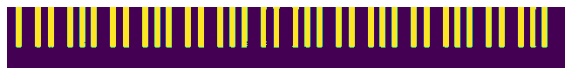

In [267]:
keyboard = Keyboard(showAnimations = False)

path = root + "videos\\video_to_process*"
vtp = glob.glob(path)
if vtp:
    camera = cv2.VideoCapture(vtp[0])
    frames = camera.get(cv2.CAP_PROP_FRAME_COUNT)
    
    isKeyboardDetected = False
    frameCounter = 0
    
    while (not isKeyboardDetected) or (frameCounter < frames):
        camera.set(cv2.CAP_PROP_POS_FRAMES, frameCounter)
        res, frame = camera.read()
        try:        
            keyboard.detectKeys(frame)
            isKeyboardDetected = keyboard.isKeyboardDetected()
            break
        except IncorrectNumberOfKeysException as error:
            frameCounter += round(frames / 500.0) * 500.0
            
    if (not isKeyboardDetected) or (frameCounter > frames):
        raise IncorrectNumberOfKeysException('The keys could not be read in this video!')
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(keyboard.getThresholdedKeyboard())
        plt.axis('off')
        plt.show()
else:
    raise VideoReadException('Video could not be read!')

# To be deleted...

For the range x:0 -> end, we assign a specify range to each key. For example, A: 0 - 10 pixels, A#: 10 - 15 pixels...

Our assumption is that the centroid of the key played will land in a discrete range with no overlap/ambiguity.

We know that black keys are skinnier than white keys, and we took the median width of the black keys above. For each black key, it's range is ***centroid - black_key_width/2 < x < centroid + black_key_width/2***.

For white keys adjacent to black keys, the above axiom provides one of the bounds.

For white keys adjacent to white keys, we simply take the mid-way point between their centroids as one of the bounds.

In [263]:
print(keyboard.getKeys())

[['A0' 9.990322580645161]
 ['A#0' 17.103216300145764]
 ['B0' 24.965888665529178]
 ['C0' 32.0096463022508]
 ['C#0' 39.64021966950064]
 ['D0' 46.957928802588995]
 ['D#0' 53.76117299025155]
 ['E0' 61.63172315206385]
 ['F0' 68.8628762541806]
 ['F#0' 76.31559654293189]
 ['G0' 82.016077170418]
 ['G#0' 89.2548470958473]
 ['A1' 95.9935691318328]
 ['A#1' 102.79410966879706]
 ['B1' 110.65515875858665]
 ['C1' 117.99679487179488]
 ['C#1' 125.52652810740378]
 ['D1' 132.5818181818182]
 ['D#1' 139.5833426287414]
 ['E1' 147.6419481009391]
 ['F1' 154.5839416058394]
 ['F#1' 162.1669708029197]
 ['G1' 168.01277955271564]
 ['G#1' 175.2531982869961]
 ['A2' 181.99032258064517]
 ['A#2' 188.66084176369537]
 ['B2' 196.5235141290788]
 ['C2' 203.98402555910542]
 ['C#2' 211.51280843958887]
 ['D2' 218.5441176470588]
 ['D#2' 225.42274375503627]
 ['E2' 233.50019949461364]
 ['F2' 240.57142857142858]
 ['F#2' 248.1552795031056]
 ['G2' 254.0128205128205]
 ['G#2' 261.24789961811234]
 ['A3' 267.96774193548384]
 ['A#3' 274.

The function below **inserts** any given value between our established key ranges. It returns an index where the given value *would* be inserted, which gives us our corresponding key pressed.

In [ ]:
note, index = getKeyPressed(full_key_list, 999)
# print(index)

# 4.1 Scenario Testing - Notes are FULLY vertical

In [ ]:
#sample piano image from youtube
img_notes = cv2.imread(root + "images\IMG_fully_vertical.png")

#converting to gray
gray_notes = cv2.cvtColor(img_notes, cv2.COLOR_BGR2GRAY)
img_notes_rgb = cv2.cvtColor(img_notes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_notes_rgb)
plt.axis('off')
plt.show()

*y_cord[1]* is the position of the top of the keyboard. We calculated this using **half** the original image, so we need to add this back in.

# I added it back paps =3

In [ ]:
#Cropped
top_keys_index = y_cord[1] + img_notes.shape[0]//2
crop_img_notes = img_notes[20:(int(top_keys_index)-30)] #Crop the top 20 pixels and bottom 30
crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(crop_img_notes)

Identify notes.

In [ ]:
crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)
# # k = 3
# # blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

# #Using standard threshold to create contrast between white/black keys
# _, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

# _, th_notes = cv2.threshold(crop_img_notes_gray, 90, 150, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(crop_img_notes_gray, cmap = "gray")
plt.show()

In [ ]:
# k = 7 #This level of blurring made it possible to just view the notes
# blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

# t1 = 15
# t2 = 105
# edged = cv2.Canny(blurred, t1, t2)

# plt.figure(figsize=(10,10))
# plt.imshow(edged, cmap = "gray")

# 4.1a - Iterating on Contours
If we have a rectangle that spans the whole screen - the caps are not detected. We need to create our **own** caps. This method uses Canny-edge detection up front.

In [ ]:
# #Count notes
# (cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = sorted(cnts, key = cv2.contourArea, reverse = True)

# #Each list within cnts is the list of contour points - 1 for each coin (total = 9)
# print("# of notes: {}".format(len(cnts)))

# #Do it on a copy
# tmp = crop_img_notes.copy()

# font = cv2.FONT_HERSHEY_SIMPLEX


# problem = []
# i = 0
# for cnt in cnts:
    
#     x,y,w,h = cv2.boundingRect(cnt)
#     cv2.rectangle(tmp,(x,y),(x+w,y+h),(0,255,0),1)
#     cv2.putText(tmp, str(w), (int(x), int(y+12)), font, 0.25, (255,0,0), 1)
    
#     if w < key_width_bl*0.9:
#         problem.append(cnt)
    
#     i+=1
    
# plt.figure(figsize = (10,10))
# plt.imshow(tmp)

For the contours with a width < 90%(?) of our calculated black key width. We extract and figure out what's going on.

In [ ]:
# flat_list = [item for sublist in problem[3] for item in sublist]
# flat_list = [item for sublist in flat_list for item in sublist]
# # flat_list[::2]

In [ ]:
# #Check if we have a PAIR - otherwise we can't match

# problem_x_indx = []
# if len(problem) %2 == 0:
#     for prblm in problem:
#         flat_list = [item for sublist in prblm for item in sublist] # First level of flattening
#         flat_list = [item for sublist in flat_list for item in sublist] # Flattens x and y into 1-D vector
#         x_indices = flat_list[::2] # Every other element
#         print(min(x_indices))

In [ ]:
# edged[1,99:110] = 255
# edged[-2, 185:196] = 255

# 4.1a Key Detection

In [ ]:
# #####################################################################################
# ####### using connected component detection algorithm to separate all the black notes
# connectivity = 8
# output = cv2.connectedComponentsWithStats(edged, connectivity, cv2.CV_32S)
# num_labels = output[0]
# labels = output[1]
# stats = output[2]
# centroids = output[3]

# final_labels = []
# note_list = [] #creating a list of all the relavent notes. 


# output = img_notes_rgb.copy()
# font = cv2.FONT_HERSHEY_SIMPLEX

# #For loop only used for displaying 
# for i in range(1, num_labels):
#     x = stats[i, cv2.CC_STAT_LEFT]
#     y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
#     w = stats[i, cv2.CC_STAT_WIDTH]
#     h = stats[i, cv2.CC_STAT_HEIGHT]
#     area = stats[i, cv2.CC_STAT_AREA]
#     (cX, cY) = centroids[i]
#     cY = cY + 20 # We cropped out the first 20 pixels
#     if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
#         final_labels.append(i)
#         cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
#         dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
#         cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
#         componentMask = (labels == i).astype("uint8") * 255
        
#         note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
#         note_list.append(note)
        
#         note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
#         cv2.putText(output, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)

# #         displayImage("Output", output)
# #         displayImage("Connected Component", componentMask)
# #         cv2.waitKey(0)

# # print(final_labels)
# # cv2.destroyAllWindows()
# plt.figure(figsize=(10,10))
# plt.imshow(output)
# plt.show()



# 4.1b - Can just use connected components

In [ ]:
k = 3
blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

#Using standard threshold to create contrast between white/black keys
_, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(th_notes, cmap = "gray")
plt.show()

In [ ]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th_notes, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

final_labels = []
note_list = [] #creating a list of all the relavent notes. 


output = img_notes_rgb.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cY = cY + 20 # We cropped out the first 20 pixels
    if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
        cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
        componentMask = (labels == i).astype("uint8") * 255
        
        note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
        note_list.append(note)
        
        note_played, _ = getKeyPressed(keyboard.getKeys(), note.centroid_x)
        cv2.putText(output, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)



plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output)
plt.show()

# 4.2 Scenario Testing - Notes are VERY close

In [ ]:
# #sample piano image from youtube
# img_notes = cv2.imread("IMG_very_close_notes.png")

# #converting to gray
# gray_notes = cv2.cvtColor(img_notes, cv2.COLOR_BGR2GRAY)
# img_notes_rgb = cv2.cvtColor(img_notes, cv2.COLOR_BGR2RGB)

# plt.imshow(img_notes_rgb)
# # plt.axis('off')
# plt.show()

In [ ]:
# #Cropped
# top_keys_index = y_cord[1] + img_notes.shape[0]//2
# crop_img_notes = img_notes[20:(int(top_keys_index)-30)] #Crop the top 20 pixels and bottom 30
# crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)

# plt.imshow(crop_img_notes)

We only need to use connected components.

In [ ]:
# k = 3
# blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

# #Using standard threshold to create contrast between white/black keys
# _, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

# plt.figure(figsize=(10,10))
# plt.imshow(th_notes, cmap = "gray")
# plt.show()

In [ ]:
# #####################################################################################
# ####### using connected component detection algorithm to separate all the black notes
# connectivity = 8
# output = cv2.connectedComponentsWithStats(th_notes, connectivity, cv2.CV_32S)
# num_labels = output[0]
# labels = output[1]
# stats = output[2]
# centroids = output[3]

# final_labels = []
# note_list = [] #creating a list of all the relavent notes. 


# output = img_notes_rgb.copy()
# font = cv2.FONT_HERSHEY_SIMPLEX

# #For loop only used for displaying 
# for i in range(1, num_labels):
#     x = stats[i, cv2.CC_STAT_LEFT]
#     y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
#     w = stats[i, cv2.CC_STAT_WIDTH]
#     h = stats[i, cv2.CC_STAT_HEIGHT]
#     area = stats[i, cv2.CC_STAT_AREA]
#     (cX, cY) = centroids[i]
#     cY = cY + 20 # We cropped out the first 20 pixels
#     if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
#         final_labels.append(i)
#         cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
#         dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
#         cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
#         componentMask = (labels == i).astype("uint8") * 255
        
#         note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
#         note_list.append(note)
        
#         note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
#         cv2.putText(output, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)



# plt.figure(figsize=(10,10))
# plt.imshow(output)
# plt.show()

# 4.3 Scenario Testing - Notes ARE connected

In [ ]:
#sample piano image from youtube
img_notes = cv2.imread(root + "images\IMG_connected_white_black.png")

#converting to gray
gray_notes = cv2.cvtColor(img_notes, cv2.COLOR_BGR2GRAY)
img_notes_rgb = cv2.cvtColor(img_notes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_notes_rgb)
plt.axis('off')
plt.show()

In [ ]:
#Cropped
top_keys_index = y_cord[1] + img_notes.shape[0]//2
crop_img_notes = img_notes[20:(int(top_keys_index)-30)] #Crop the top 20 pixels and bottom 30
crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(crop_img_notes)

In [ ]:
k = 3
blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

#Using standard threshold to create contrast between white/black keys
_, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(th_notes, cmap = "gray")
plt.show()

# 4.3a - Use Connected Components
Then figure out if any region has a component that is much larger than the white note width.

If yes, apply a mask on this and then use Canny-edge detection.

In [ ]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th_notes, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

In [ ]:
# num_labels

In [ ]:
# labels

In [ ]:
# stats

In [ ]:
# centroids

In [ ]:
#Loop through all the connected components
for i in range(1, num_labels):
    
    curr_connected_w = stats[i, cv2.CC_STAT_WIDTH]
    
    #Determine if the WIDTH is much bigger than the width of a white key
    if curr_connected_w > key_width_w*1.1:
        print(i)
        componentMask = (labels == i).astype("uint8") * 255

In [ ]:
# componentMask

In [ ]:
threshMask = cv2.bitwise_and(crop_img_notes_gray, crop_img_notes_gray, mask = componentMask)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(threshMask, cmap = "gray")

# 4.3b Histogram
Use a Histogram to compute the dominant non-black (i.e. not the background) colour. Use ~90% of this to threshold the image.

In [ ]:
#Histogram
#cv2.calcHist(images,channels,mask,histSize,ranges)
bin_scaler = 4

hist = cv2.calcHist([threshMask], [0], None, [int(256/4)], [1, 256])
    #Grayscale has one channel so we use [0]
    #No mask,
    #We'll use 256 bins (i.e. count each and every - no binning)
    #Possible values range from 0 to 256

plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
# plt.xlim([0, 256])
# plt.figure(figsize=(20,10))

# Colour thresholding

In [ ]:
T = hist.argmax() * bin_scaler * .9
th2 = threshMask.copy()
th2[th2>T] = 255
th2[th2<T] = 0

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(th2, cmap = "gray")

# Detect the first set of keys (white)

In [ ]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th2, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

final_labels = []
note_list = [] #creating a list of all the relavent notes. 


output = img_notes_rgb.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cY = cY + 20 # We cropped out the first 20 pixels
    if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
        cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
        componentMask = (labels == i).astype("uint8") * 255
        
        note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
        note_list.append(note)
        
        note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
        cv2.putText(output, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)



plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output)
plt.show()

# Now the second set of keys (black) 

In [ ]:
tst = threshMask.copy()
tst[tst>T] = 0

plt.imshow(tst, cmap = "gray")

In [ ]:
k = 3
blurred = cv2.GaussianBlur(tst, (k,k), 0)

#Using standard threshold to create contrast between white/black keys
_, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(th_notes, cmap = "gray")
plt.show()

In [ ]:
#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th_notes, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

final_labels = []
note_list = [] #creating a list of all the relavent notes. 


output = img_notes_rgb.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

#For loop only used for displaying 
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cY = cY + 20 # We cropped out the first 20 pixels
    if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
        final_labels.append(i)
        cv2.rectangle(output, (x,y), (x+w, y+h), (255,0,0),1)
        dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
        cv2.circle(output, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)
        componentMask = (labels == i).astype("uint8") * 255
        
        note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
        note_list.append(note)
        
        note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
        cv2.putText(output, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)



plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output)
plt.show()

# 5. Putting it Together
First, utilize ConnectedComponents to determine our keys. If the width of a connect component is ~10% greater than the defined median width of a white key, we assume that these keys needs to be split.

The only possibly connection would be a black key and a white key because black-black will never be fully connected nor will white-white. Thus, we can utilize thresholds to segment each connected key.

With this, we remove the original connected components and then append the new separated keys.

In [ ]:
#sample piano image from youtube
img_notes = cv2.imread(root + "images/IMG_connected_white_black.png")

#converting to gray
gray_notes = cv2.cvtColor(img_notes, cv2.COLOR_BGR2GRAY)
img_notes_rgb = cv2.cvtColor(img_notes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_notes_rgb)
plt.axis('off')
plt.show()

In [ ]:
#Cropped
top_keys_index = y_cord[1] + img_notes.shape[0]//2
crop_img_notes = img_notes[20:(int(top_keys_index)-30)] #Crop the top 20 pixels and bottom 30
crop_img_notes_gray = cv2.cvtColor(crop_img_notes, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(crop_img_notes)

In [ ]:
k = 3
blurred = cv2.GaussianBlur(crop_img_notes_gray, (k,k), 0)

#Using standard threshold to create contrast between white/black keys
_, th_notes = cv2.threshold(blurred, 90, 150, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))
plt.imshow(th_notes, cmap = "gray")
plt.show()

In [ ]:
#We have a thresholded image for use to use ConnectedComponents on

#####################################################################################
####### using connected component detection algorithm to separate all the black notes
connectivity = 8
output = cv2.connectedComponentsWithStats(th_notes, connectivity, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats = output[2]
centroids = output[3]

indices_to_pop = []


output_img = img_notes_rgb.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

note_list = []

i=1
#Loop through all the connected components
while i < len(stats):
    
    curr_connected_w = stats[i, cv2.CC_STAT_WIDTH]
    
    #Determine if the WIDTH is much bigger than the width of a white key
    if curr_connected_w > key_width_w*1.1:
        
        #Threshold just the large component of interest
        componentMask = (labels == i).astype("uint8") * 255
        threshMask = cv2.bitwise_and(crop_img_notes_gray, crop_img_notes_gray, mask = componentMask) #Replace this with video frame

        # Histogram segregation of black/white key
        # Grayscale has one channel so we use [0]
            #Possible values range from 0 to 256
        bin_scaler = 4
        hist = cv2.calcHist([threshMask], [0], None, [256/bin_scaler], [1, 256])
            

        #Use a Histogram to compute the dominant non-black (i.e. not the background) colour. Use ~90% of this to threshold the image.
        T = hist.argmax() * bin_scaler * .9
        th1 = threshMask.copy()
        th1[th1>T] = 255
        th1[th1<T] = 0

        #Detect the first set of keys
        connectivity = 8
        output = cv2.connectedComponentsWithStats(th1, connectivity, cv2.CV_32S)
        num_labels_th1 = output[0]
        labels_th1 = output[1]
        stats_th1 = output[2]
        centroids_th1 = output[3]
        
        #Loop through components and determine which ones may be keys
        for j in range(1, num_labels_th1):
            area = stats_th1[j, cv2.CC_STAT_AREA]
            if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be keys)
                
                if j > 1:
                    ## We've added another label
                    num_labels +=1 
                    i +=1
                
                ##Within labels_th1, we have a matrix that is the same size of the image that holds our split component
                #First, cut out the original "fat" label
                fat_mask = labels != i
                labels = labels * fat_mask
                
                #Next, increment each label above the cut one up to accomodate the new label
                higher_mask = labels > i
                labels = labels + higher_mask
                
                #Then append our segregated key
                new_mask = labels_th1 == j
                new_labels = labels_th1 * new_mask
                new_labels = i * new_labels
                labels = labels + new_labels
                
                ##Remove the original index for the stats and then add the new one
                stats = np.delete(stats,i,0)
                stats = np.insert(stats,i,stats_th1[j],0)
                
                ##Remove the original index for the centroids and then add the new one
                centroids = np.delete(centroids,i,0)
                centroids = np.insert(centroids,i,centroids_th1[j],0)
                
                #Plot immediately so indexing doesn't get messed up
                x = stats[i, cv2.CC_STAT_LEFT]
                y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
                w = stats[i, cv2.CC_STAT_WIDTH]
                h = stats[i, cv2.CC_STAT_HEIGHT]
                area = stats[i, cv2.CC_STAT_AREA]
                (cX, cY) = centroids[i]
                cY = cY + 20 # We cropped out the first 20 pixels
                cv2.rectangle(output_img, (x,y), (x+w, y+h), (255,0,0),1)
                dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
                cv2.circle(output_img, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)

                note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
                note_list.append(note)

                note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
                cv2.putText(output_img, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)

                
                
        
            #Detect the next set of keys
            th2 = threshMask.copy()
            th2[th2>T] = 0        
            k = 3
            blurred_th2 = cv2.GaussianBlur(th2, (k,k), 0)

            #Using standard threshold to create contrast between white/black keys
            _, th2_notes = cv2.threshold(blurred_th2, 90, 150, cv2.THRESH_BINARY)

            #Detect the second set of keys
            connectivity = 8
            output = cv2.connectedComponentsWithStats(th2_notes, connectivity, cv2.CV_32S)
            num_labels_th2 = output[0]
            labels_th2 = output[1]
            stats_th2 = output[2]
            centroids_th2 = output[3]

            #Loop through components and determine which ones may be keys
            for k in range(1, num_labels_th2):
                area = stats_th2[k, cv2.CC_STAT_AREA]
                if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be keys)

                    if k > 1:
                        ## We've added another label
                        num_labels +=1 
                        i+=1

                    ##Within labels_th1, we have a matrix that is the same size of the image that holds our split component
                    #For the second key WE DON'T NEED TO CUT anything
    #                 fat_mask = labels != i
    #                 labels = labels * fat_mask

                    #Next, increment each label above the cut one up to accomodate the new label
                    higher_mask = labels > i + 1
                    labels = labels + higher_mask

                    #Then append our segregated key
                    new_mask = labels_th2 == k
                    new_labels = labels_th2 * new_mask
                    new_labels = (i + 1) * new_labels
                    labels = labels + new_labels

                    ##Remove the original index for the stats and then add the new one
    #                 stats = np.delete(stats,(i+1),0)
                    stats = np.insert(stats,(i+1),stats_th2[k],0)

                    ##Remove the original index for the centroids and then add the new one
    #                 centroids = np.delete(centroids,(i+1),0)
                    centroids = np.insert(centroids,(i+1),centroids_th2[k],0)
        
                    #Plot immediately so indexing doesn't get messed up
                    x = stats[i, cv2.CC_STAT_LEFT]
                    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
                    w = stats[i, cv2.CC_STAT_WIDTH]
                    h = stats[i, cv2.CC_STAT_HEIGHT]
                    area = stats[i, cv2.CC_STAT_AREA]
                    (cX, cY) = centroids[i]
                    cY = cY + 20 # We cropped out the first 20 pixels
                    cv2.rectangle(output_img, (x,y), (x+w, y+h), (255,0,0),1)
                    dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
                    cv2.circle(output_img, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)

                    note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
                    note_list.append(note)

                    note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
                    cv2.putText(output_img, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)

    else:
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]
        cY = cY + 20 # We cropped out the first 20 pixels
        if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
            cv2.rectangle(output_img, (x,y), (x+w, y+h), (255,0,0),1)
            dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
            cv2.circle(output_img, (int(cX), int(cY+dist_to_edge)), 1, (0,122,255), 3)

            note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
            note_list.append(note)

            note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
            cv2.putText(output_img, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)

    i+=1
    
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(output_img)
plt.show()

# 6. Do it on a video

In [ ]:
camera = cv2.VideoCapture(root + 'videos/video_to_process.mp4')

frames = camera.get(cv2.CAP_PROP_FRAME_COUNT)
fps = camera.get(cv2.CAP_PROP_FPS)
seconds_per_frame = fps/frames
counter = 0

notes_pressed = []

keys_timed = []
for x in full_key_list:
    keys_timed.append([x[0]])


keys_timed_update = []
for x in full_key_list:
    keys_timed_update.append([x[0]])

    
testing_screen = []
testing_mask = []

while (camera.isOpened()):
    #print(counter)
    #print('-'*100)
    
    #grabbed is a boolean than tells us if there is a valid frame
    (grabbed, frame) = camera.read()

    frame_number = camera.get(cv2.CAP_PROP_POS_FRAMES)
    elapsed = frame_number/fps

    
    if not grabbed:
        break

    counter += seconds_per_frame
        
         
    frame = imutils.resize(frame,width = keys.shape[1]) #resize or else it won't work
    #print(frame.shape)
    
    crop_frame = frame[20:int(top_keys_index)-50] #Crop the top 20 pixels and bottom 10
    
    # threshold the cropped and grayed image
    crop_frame_gray = cv2.cvtColor(crop_frame, cv2.COLOR_BGR2GRAY)
    _, th_crop_frame = cv2.threshold(crop_frame_gray, 90, 150, cv2.THRESH_BINARY)

    
    #We have a thresholded image for use to use ConnectedComponents on
    #####################################################################################
    ####### using connected component detection algorithm to separate all the black notes
    connectivity = 8
    output = cv2.connectedComponentsWithStats(th_crop_frame, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    indices_to_pop = []


    output_img = frame.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX

    
#     print("-"*50)
#     print("new frame")
    i=1
    #Loop through all the connected components
    while i < len(stats):

        curr_connected_w = stats[i, cv2.CC_STAT_WIDTH]

        #Determine if the WIDTH is much bigger than the width of a white key and less than 4x? (So we don't get extraneous video text, etc.)
        if curr_connected_w > key_width_w*1.25 and curr_connected_w < key_width_w*4:
            


            #Threshold just the large component of interest
            componentMask = (labels == i).astype("uint8") * 255
            threshMask = cv2.bitwise_and(crop_frame_gray, crop_frame_gray, mask = componentMask) #Replace this with video frame

#             print("We are here.")
#             testing_screen.append(frame.copy())
#             testing_mask.append(threshMask.copy())
            
            # Histogram segregation of black/white key
            # Grayscale has one channel so we use [0]
                #Possible values range from 0 to 256
            bin_scaler = 4
            hist = cv2.calcHist([threshMask], [0], None, [int(256/bin_scaler)], [1, 256])


            #Use a Histogram to compute the dominant non-black (i.e. not the background) colour. Use ~90% of this to threshold the image.
            T = hist.argmax() * bin_scaler * .9
            th1 = threshMask.copy()
            th1[th1>T] = 255
            th1[th1<T] = 0

            #Detect the first set of keys
            connectivity = 8
            output = cv2.connectedComponentsWithStats(th1, connectivity, cv2.CV_32S)
            num_labels_th1 = output[0]
            labels_th1 = output[1]
            stats_th1 = output[2]
            centroids_th1 = output[3]

            #Loop through components and determine which ones may be keys
            for j in range(1, num_labels_th1):
                area = stats_th1[j, cv2.CC_STAT_AREA]
                if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be keys)

                    if j > 1:
                        ## We've added another label
                        num_labels +=1 
                        i +=1

                    ##Within labels_th1, we have a matrix that is the same size of the image that holds our split component
                    #First, cut out the original "fat" label
                    fat_mask = labels != i
                    labels = labels * fat_mask

                    #Next, increment each label above the cut one up to accomodate the new label
                    higher_mask = labels > i
                    labels = labels + higher_mask

                    #Then append our segregated key
                    new_mask = labels_th1 == j
                    new_labels = labels_th1 * new_mask
                    new_labels = i * new_labels
                    labels = labels + new_labels

                    ##Remove the original index for the stats and then add the new one
                    if i < len(stats):
                        stats = np.delete(stats,i,0)
                        stats = np.insert(stats,i,stats_th1[j],0)
                    elif j == 1:
                        stats = stats[:-1,:]
                        stats = np.concatenate((stats,stats_th1[j][None,:]),0)
                    else:
                        stats = np.concatenate((stats,stats_th1[j][None,:]),0)

                    ##Remove the original index for the centroids and then add the new one
                    if i < len(centroids):
                        centroids = np.delete(centroids,i,0)
                        centroids = np.insert(centroids,i,centroids_th1[j],0)
                    elif j==1:
                        centroids = centroids[:-1,:]
                        centroids = np.concatenate((centroids,centroids_th1[j][None,:]),0)  
                    else:
                        centroids = np.concatenate((centroids,centroids_th1[j][None,:]),0)  
                        

                        
                    print("i: {}, stats: {}".format(i,len(stats)))
                    #Plot immediately so indexing doesn't get messed up
                    x = stats[i, cv2.CC_STAT_LEFT]
                    y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
                    w = stats[i, cv2.CC_STAT_WIDTH]
                    h = stats[i, cv2.CC_STAT_HEIGHT]
                    area = stats[i, cv2.CC_STAT_AREA]
                    (cX, cY) = centroids[i]
                    cY = cY + 20 # We cropped out the first 20 pixels
                    cv2.rectangle(output_img, (x,y), (x+w, y+h), (0,0,255),1)
                    dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
                    top_dot = cY-dist_to_edge
                    bottom_dot = cY+dist_to_edge
                    cv2.circle(output_img, (int(cX), int(bottom_dot)), 1, (0,122,255), 3)
                    cv2.circle(output_img, (int(cX), int(top_dot)), 1, (0,122,255), 3)

                    note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
            
            
                    if ( (int(bottom_dot) >= int(y_cord[0])) and (int(bottom_dot) <= int(y_cord[0])+2) ):
                        note_played, index = getKeyPressed(full_key_list, cX)
                        #print(str(note_played) + " at " + str(counter))
                        keys_timed_update[index].append([elapsed])

                    if ( (int(top_dot) >= int(y_cord[0])) and (int(top_dot) <= int(y_cord[0])+2) ):
                        note_played, index = getKeyPressed(full_key_list, cX)
                        keys_timed_update[index].append([elapsed])

                    note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
                    cv2.putText(output_img, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)




                #Detect the next set of keys
                th2 = threshMask.copy()
                th2[th2>T] = 0        
                k = 3
                blurred_th2 = cv2.GaussianBlur(th2, (k,k), 0)

                #Using standard threshold to create contrast between white/black keys
                _, th2_notes = cv2.threshold(blurred_th2, 90, 150, cv2.THRESH_BINARY)

                #Detect the second set of keys
                connectivity = 8
                output = cv2.connectedComponentsWithStats(th2_notes, connectivity, cv2.CV_32S)
                num_labels_th2 = output[0]
                labels_th2 = output[1]
                stats_th2 = output[2]
                centroids_th2 = output[3]

                #Loop through components and determine which ones may be keys
                for k in range(1, num_labels_th2):
                    area = stats_th2[k, cv2.CC_STAT_AREA]
                    if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be keys)

                        if k > 1:
                            ## We've added another label
                            num_labels +=1 
                            i+=1

                        ##Within labels_th1, we have a matrix that is the same size of the image that holds our split component
                        #For the second key WE DON'T NEED TO CUT anything
        #                 fat_mask = labels != i
        #                 labels = labels * fat_mask

                        #Next, increment each label above the cut one up to accomodate the new label
                        higher_mask = labels > i + 1
                        labels = labels + higher_mask

                        #Then append our segregated key
                        new_mask = labels_th2 == k
                        new_labels = labels_th2 * new_mask
                        new_labels = (i + 1) * new_labels
                        labels = labels + new_labels

                        ##Add
                        if i < len(stats):
                            stats = np.insert(stats,(i+1),stats_th2[k],0)                       
                        else:
                            stats = np.concatenate((stats,stats_th2[k][None,:]),0)
                        

                        ##Add
                        if i < len(centroids):
                            centroids = np.insert(centroids,(i+1),centroids_th2[k],0)
                        else:
                            centroids = np.concatenate((centroids,centroids_th2[k][None,:]),0)

                        #Plot immediately so indexing doesn't get messed up
                        x = stats[i, cv2.CC_STAT_LEFT]
                        y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
                        w = stats[i, cv2.CC_STAT_WIDTH]
                        h = stats[i, cv2.CC_STAT_HEIGHT]
                        area = stats[i, cv2.CC_STAT_AREA]
                        (cX, cY) = centroids[i]
                        cY = cY + 20 # We cropped out the first 20 pixels
                        cv2.rectangle(output_img, (x,y), (x+w, y+h), (0,0,255),1)
                        dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
                        top_dot = cY-dist_to_edge
                        bottom_dot = cY+dist_to_edge
                        cv2.circle(output_img, (int(cX), int(bottom_dot)), 1, (0,122,255), 3)
                        cv2.circle(output_img, (int(cX), int(top_dot)), 1, (0,122,255), 3)

                        note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
            
            
                        if ( (int(bottom_dot) >= int(y_cord[0])) and (int(bottom_dot) <= int(y_cord[0])+2) ):
                            note_played, index = getKeyPressed(full_key_list, cX)
                            #print(str(note_played) + " at " + str(counter))
                            keys_timed_update[index].append([elapsed])

                        if ( (int(top_dot) >= int(y_cord[0])) and (int(top_dot) <= int(y_cord[0])+2) ):
                            note_played, index = getKeyPressed(full_key_list, cX)
                            keys_timed_update[index].append([elapsed])

                        note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
                        cv2.putText(output_img, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)

        else:
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP] + 20 # We cropped out the first 20 pixels
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            (cX, cY) = centroids[i]
            cY = cY + 20 # We cropped out the first 20 pixels
            if (20 < area < np.inf): #filtering out relavent detections (the ones big enough to be black keys)
                cv2.rectangle(output_img, (x,y), (x+w, y+h), (0,0,255),2)
                dist_to_edge = h/2 #getting the distance from centroid to bottom edge for better detection later on
                top_dot = cY-dist_to_edge
                bottom_dot = cY+dist_to_edge
                cv2.circle(output_img, (int(cX), int(bottom_dot)), 1, (0,122,255), 3)
                cv2.circle(output_img, (int(cX), int(top_dot)), 1, (0,122,255), 3)

                note = Note(cX, cY+dist_to_edge) #creating note object and adding to list
            
                if ( (int(bottom_dot) >= int(y_cord[0])) and (int(bottom_dot) <= int(y_cord[0])+2) ):
                    note_played, index = getKeyPressed(full_key_list, cX)
                    #print(str(note_played) + " at " + str(counter))
                    keys_timed_update[index].append([elapsed])

                if ( (int(top_dot) >= int(y_cord[0])) and (int(top_dot) <= int(y_cord[0])+2) ):
                    note_played, index = getKeyPressed(full_key_list, cX)
                    keys_timed_update[index].append([elapsed])

                note_played, _ = getKeyPressed(full_key_list, note.centroid_x)
                cv2.putText(output_img, note_played, (int(note.centroid_x), int(note.centroid_y)), font, 0.5, (0,255,0), 1)

        i+=1
    
    
    #Show the frame + drawn rectangle
    cv2.imshow("Video", output_img)

    #Can break early by pressing "q"
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
# print(keys_timed_update)    
camera.release()
cv2.destroyAllWindows()

In [ ]:
# i

In [ ]:
# stats.shape